In [73]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-aug-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-aug-2022/train.csv
/kaggle/input/tabular-playground-series-aug-2022/test.csv


In [74]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import VotingClassifier

import matplotlib.pyplot as plt

random_seed = 256

In [75]:
train = pd.read_csv('/kaggle/input/tabular-playground-series-aug-2022/train.csv', index_col='id')
train

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26565,E,158.95,material_7,material_6,6,9,6,16,4,16.301,...,NaN,12.177,17.942,10.112,15.795,18.572,16.144,NaN,729.131,0
26566,E,146.02,material_7,material_6,6,9,10,12,8,17.543,...,11.242,14.179,20.564,10.234,14.450,14.322,13.146,16.471,853.924,0
26567,E,115.62,material_7,material_6,6,9,1,10,1,15.670,...,11.407,16.437,17.476,8.668,15.069,16.599,15.590,14.065,750.364,0


In [76]:
# Check for missing values
train.isna().sum().sum()

20273

In [77]:
# Check more detail for missing values
print('Col name', '\t\t Null values', '\t dtype')
print('=================================================')
for col in train.columns:
        print(col, '\t\t',  train[col].isnull().sum(), '\t\t', train[col].dtype)

Col name 		 Null values 	 dtype
product_code 		 0 		 object
loading 		 250 		 float64
attribute_0 		 0 		 object
attribute_1 		 0 		 object
attribute_2 		 0 		 int64
attribute_3 		 0 		 int64
measurement_0 		 0 		 int64
measurement_1 		 0 		 int64
measurement_2 		 0 		 int64
measurement_3 		 381 		 float64
measurement_4 		 538 		 float64
measurement_5 		 676 		 float64
measurement_6 		 796 		 float64
measurement_7 		 937 		 float64
measurement_8 		 1048 		 float64
measurement_9 		 1227 		 float64
measurement_10 		 1300 		 float64
measurement_11 		 1468 		 float64
measurement_12 		 1601 		 float64
measurement_13 		 1774 		 float64
measurement_14 		 1874 		 float64
measurement_15 		 2009 		 float64
measurement_16 		 2110 		 float64
measurement_17 		 2284 		 float64
failure 		 0 		 int64


In [78]:
# Check for duplicated rows
train.duplicated().sum()

0

In [79]:
# Check categorical data in train
for col in ['product_code', 'attribute_0', 'attribute_1']:
    print(col, ': \t', train[col].unique())

product_code : 	 ['A' 'B' 'C' 'D' 'E']
attribute_0 : 	 ['material_7' 'material_5']
attribute_1 : 	 ['material_8' 'material_5' 'material_6']


In [80]:
# Check categorical data in test
test = pd.read_csv('/kaggle/input/tabular-playground-series-aug-2022/test.csv', index_col='id')

for col in ['product_code', 'attribute_0', 'attribute_1']:
    print(col, ': \t', test[col].unique())

product_code : 	 ['F' 'G' 'H' 'I']
attribute_0 : 	 ['material_5' 'material_7']
attribute_1 : 	 ['material_6' 'material_7' 'material_5']


In [81]:
# Get X data. since product_code is different between train and test, will be dropped
X_train = train.drop(['product_code', 'failure'], axis=1)
X_test = test.drop(['product_code'], axis=1)

# Get features names
feature_names = X_train.columns.values.tolist()

# Categorical encoder. since categories are shared, define one unique encoder
encoder = LabelEncoder()
encoder.fit(['material_5', 'material_6', 'material_7', 'material_8'])
for col in ['attribute_0', 'attribute_1']:
    X_train[col] = encoder.transform(X_train[col])
    X_test[col] = encoder.transform(X_test[col])

# Get y data
y_train = pd.Series(train['failure'])

In [82]:
#for col in X_train.columns:
#    X_train[col].fillna(X_train[col].mean(), inplace = True)
    
# Check more detail for missing values
#print('Col name', '\t\t Null values', '\t dtype')
#print('=================================================')
#for col in X_train.columns:
#        print(col, '\t\t',  X_train[col].isnull().sum(), '\t\t', X_train[col].dtype)

In [83]:
# Imputing null values
# Create our imputer to replace missing values with the mean e.g.
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_train)

# Impute data for train and test
X_train = imp.transform(X_train)
X_test = imp.transform(X_test)

## Model Creation
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [84]:
# By default model
params = {#'n_estimators' : 200,
          #'criterion' : 'gini',
          #'max_depth' : None,
          #'min_samples_split' : 2,
          #'min_samples_leaf' : 1,
          #'min_weight_fraction_leaf' : 0.0,
          #'max_features' : 'auto',
          #'max_leaf_nodes' : None, 
          #'min_impurity_decrease' : 0.0, 
          #'bootstrap' : True, 
          #'oob_score' : False, 
          #'warm_start' : False, 
          #'class_weight' : None, 
          #'ccp_alpha' : 0.0, 
          #'max_samples' : None
         }

model = RandomForestClassifier(**params,
                               random_state=random_seed,
                               n_jobs=-1, 
                               verbose=0, 
                               )

## Cross Validation
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html<br>
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html<br>
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter<br>

In [85]:
cv = StratifiedKFold(n_splits=5)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
#scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

scores.mean()

# scores (mean): x
# Public score: x

0.5273264343197139

In [86]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 256,
 'verbose': 0,
 'warm_start': False}

## Optuna optimization

In [87]:
import optuna

In [88]:
def objective(trial):
       
    n_estimators = trial.suggest_int('n_estimators', 200, 1000)
    max_depth = trial.suggest_int('max_depth', 8, 32)
    factor = max(2,int(n_estimators/400))
    min_samples_split = trial.suggest_int('min_samples_split', factor, 16)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', factor-1, min_samples_split-1)
    
    params = {'n_estimators': n_estimators,
              'max_depth': max_depth,
              'min_samples_split' : min_samples_split, 
              'min_samples_leaf' : min_samples_leaf, 
             }

    model = RandomForestClassifier(**params,
                                   random_state=random_seed,
                                   n_jobs=-1, 
                                   verbose=0, 
                                   )
    
    cv = StratifiedKFold(n_splits=5)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    #scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
        
    return scores.mean()

In [89]:
# Create Optuna Trial
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler(seed=random_seed))

# Run trials
#study.optimize(objective, n_trials = 10)
study.optimize(objective, timeout = int(3600*5))    # an hour * X

[I 2022-08-11 11:49:11,435] A new study created in memory with name: no-name-d8049c59-3b80-4aca-b308-975e0386ac17
[I 2022-08-11 11:49:54,442] Trial 0 finished with value: 0.5365686701088245 and parameters: {'n_estimators': 236, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.5365686701088245.
[I 2022-08-11 11:50:30,854] Trial 1 finished with value: 0.5434599991332757 and parameters: {'n_estimators': 220, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.5434599991332757.
[I 2022-08-11 11:52:38,894] Trial 2 finished with value: 0.5521585032692052 and parameters: {'n_estimators': 845, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.5521585032692052.
[I 2022-08-11 11:54:22,101] Trial 3 finished with value: 0.5515396080066158 and parameters: {'n_estimators': 636, 'max_depth': 21, 'min_samples_split': 16, 'min_samples_leaf': 6}. Best is trial 2 with valu

In [90]:
# Best trial
print('Best trial score:', study.best_trial.value)
study.best_trial.params

Best trial score: 0.5713993830031086


{'n_estimators': 294,
 'max_depth': 11,
 'min_samples_split': 14,
 'min_samples_leaf': 13}

In [91]:
# Create model with best trial parameters
params = {'n_estimators': study.best_trial.params['n_estimators'],
          'max_depth': study.best_trial.params['max_depth'],
          'min_samples_split' : study.best_trial.params['min_samples_split'], 
          'min_samples_leaf' : study.best_trial.params['min_samples_leaf'], 
         }

best_model = RandomForestClassifier(**params,
                                    random_state=random_seed,
                                    n_jobs=-1, 
                                    verbose=0, 
                                    )

In [92]:
best_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 11,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 13,
 'min_samples_split': 14,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 294,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 256,
 'verbose': 0,
 'warm_start': False}

## Train Model

In [93]:
# Train best model with all train data
best_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=11, min_samples_leaf=13, min_samples_split=14,
                       n_estimators=294, n_jobs=-1, random_state=256)

## Features Importance

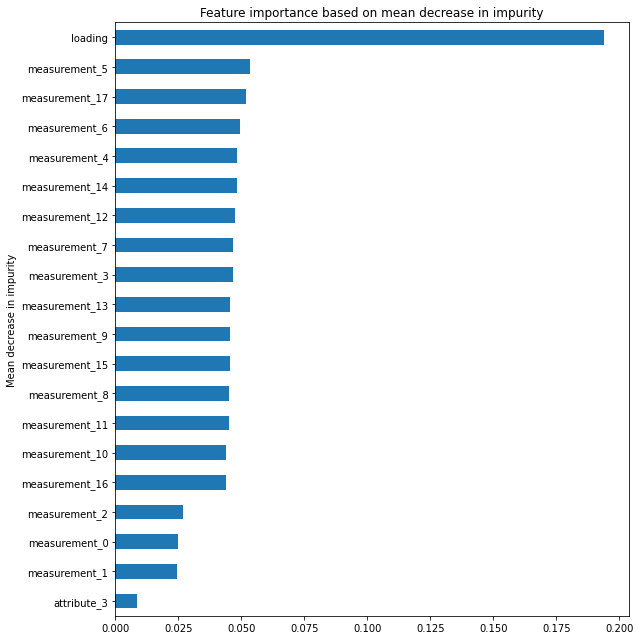

In [95]:
# Get features importances
importances = best_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)
model_importances = pd.Series(importances, index=feature_names).sort_values(ascending=True)[-20:]
# Plot features importances
fig, ax = plt.subplots(figsize=(9,9))
model_importances.plot.barh()   #(yerr=std, ax=ax)
ax.set_title("Feature importance based on mean decrease in impurity")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Submission

In [125]:
prediction = best_model.predict(X_test).squeeze()
probabilities = best_model.predict_proba(X_test)[:,1].squeeze()

row_id =  test.index.values
submission = pd.DataFrame({'id' : row_id, 'failure' : probabilities})

In [126]:
submission.to_csv('submission.csv', index=False)